In [1]:
import os

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

import cv2 as cv
import matplotlib.pyplot as plt

### Reading data

In [2]:
def read_dataset(path, size=64):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
    )
    
    X, y = zip(*ds)
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    return X, y

In [3]:
train_X, train_y = read_dataset('data/train/')
test_X, test_y = read_dataset('data/test/')
labels = sorted(os.listdir('data/train'))

Found 10019 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


### Gray

In [4]:
def cvt_to_gray(images):
    gray_images = []
    for rgb_image in images:
        gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY)
        gray_images.append(gray_image)
    gray_images = np.array(gray_images)
    gray_images = gray_images[..., np.newaxis]
    return gray_images

In [133]:
gray_train_X = cvt_to_gray(train_X)
gray_test_X = cvt_to_gray(test_X)
gray_train_X.shape, gray_test_X.shape

((10019, 64, 64, 1), (353, 64, 64, 1))

In [171]:
gray_train_X = np.abs(gray_train_X)
gray_test_X = np.abs(gray_test_X)

### Gradients

In [5]:
def get_gradients(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    
    sobelx = cv.Sobel(gray_image, cv.CV_64F,1,0,ksize=3)
    sobely = cv.Sobel(gray_image, cv.CV_64F,0,1,ksize=3)
    sobelxy = cv.Sobel(gray_image, cv.CV_64F,1,1,ksize=3)
    # laplacian = cv.Laplacian(gray_image, cv.CV_64F)
    
    return [sobelx, sobely, sobelxy]

In [6]:
def cvt_to_gradients(images):
    grad_images = []
    for rgb_image in images:
        gradients = get_gradients(rgb_image)
        grad_images.append(gradients)
    grad_images = np.array(grad_images)
    grad_images = np.transpose(grad_images, (0, 2, 3, 1))
    return grad_images

In [7]:
grad_train_X = cvt_to_gradients(train_X)
grad_test_X = cvt_to_gradients(test_X)
grad_train_X.shape, grad_test_X.shape

((10019, 64, 64, 3), (500, 64, 64, 3))

In [8]:
np.max(grad_train_X), np.min(grad_train_X)

(3.848439373075962, -3.870525425300002)

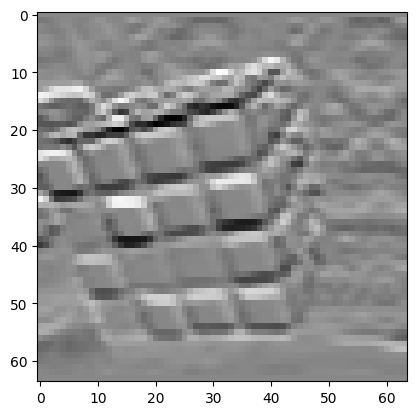

In [140]:
plt.imshow(grad_train_X[402, ..., 1], 'gray')

In [9]:
model = Sequential([
    layers.Input(shape=(None, None, 3)),
    layers.Resizing(64, 64),
    # layers.RandomFlip('horizontal'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       7

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(grad_train_X, train_y, validation_data=(grad_test_X, test_y), epochs=40, batch_size=64)

Epoch 1/40
157/157 [==============================] - 7s 13ms/step - loss: 1.9638 - accuracy: 0.2620 - val_loss: 2.0688 - val_accuracy: 0.3220
Epoch 2/40
157/157 [==============================] - 2s 10ms/step - loss: 0.9649 - accuracy: 0.6627 - val_loss: 3.0420 - val_accuracy: 0.3940
Epoch 3/40
157/157 [==============================] - 2s 10ms/step - loss: 0.5161 - accuracy: 0.8267 - val_loss: 3.2168 - val_accuracy: 0.4620
Epoch 4/40
157/157 [==============================] - 2s 10ms/step - loss: 0.2815 - accuracy: 0.9075 - val_loss: 4.5929 - val_accuracy: 0.4840
Epoch 5/40
157/157 [==============================] - 2s 10ms/step - loss: 0.1817 - accuracy: 0.9403 - val_loss: 4.0145 - val_accuracy: 0.5280
Epoch 6/40
157/157 [==============================] - 2s 10ms/step - loss: 0.1101 - accuracy: 0.9680 - val_loss: 5.6620 - val_accuracy: 0.5360
Epoch 7/40
157/157 [==============================] - 2s 10ms/step - loss: 0.0786 - accuracy: 0.9769 - val_loss: 5.4683 - val_accuracy: 0.6000

16/16 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.47      0.34      0.40        50
           1       0.78      0.28      0.41        50
           2       0.43      0.80      0.56        50
           3       0.43      0.74      0.54        50
           4       0.52      0.48      0.50        50
           5       0.75      0.96      0.84        50
           6       0.65      0.72      0.69        50
           7       1.00      0.44      0.61        50
           8       0.56      0.44      0.49        50
           9       0.74      0.58      0.65        50

    accuracy                           0.58       500
   macro avg       0.63      0.58      0.57       500
weighted avg       0.63      0.58      0.57       500



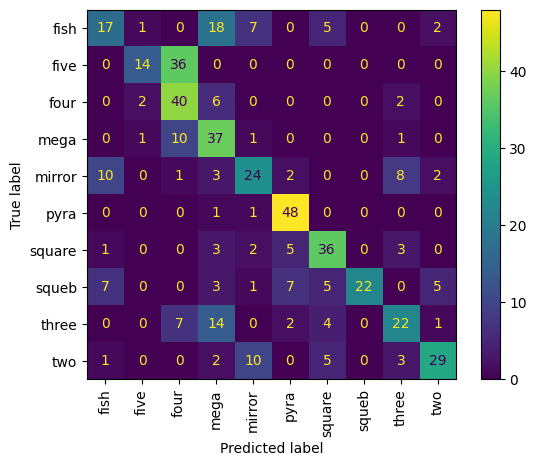

In [13]:
predictions = model.predict(grad_test_X)
true_classes = np.argmax(test_y, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    display_labels=labels, 
    xticks_rotation='vertical',
);